<a href="https://colab.research.google.com/github/chaoers/icm2021-2105298-finalist/blob/main/code_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# use in jupyter notebook

%matplotlib inline

In [ ]:
# import package

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, leaders
from scipy.cluster import hierarchy
from scipy.sparse import csr_matrix
import networkx as nx
import seaborn as sns
import math

sc = StandardScaler()

sns.set_style("ticks")

sns.despine()

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! mkdir res img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘res’: File exists
mkdir: cannot create directory ‘img’: File exists


In [ ]:
# import source data

# file dir
# fullFile = "./data/full_music_data.csv"
# influenceFile = "./data/influence_data.csv"
# influenceFile = "/content/drive/MyDrive/data/influence_data.csv"
# fullFileRes = "./data/full_data.csv"
# fullFileRes = "/content/drive/MyDrive/data/full_data.csv"
# artistFile = "./data/data_by_artist.csv"
# artistFile = "/content/drive/MyDrive/data/data_by_artist.csv"

influenceFile = "/content/drive/MyDrive/mcm/source_data/influence_data.csv"
fullFileRes = "/content/drive/MyDrive/mcm/source_data/full_music_data.csv"
artistFile = "/content/drive/MyDrive/mcm/source_data/data_by_artist.csv"

# import some result data
# sixGenresFile = './data/6data.csv'
sixGenresFile = "/content/drive/MyDrive/mcm/data/6data.csv"

# read data
fullData = pd.read_csv(fullFileRes)
influenceData = pd.read_csv(influenceFile)
artistData = pd.read_csv(artistFile)

sixData = pd.read_csv(sixGenresFile)

In [ ]:
# const genre group

genre = {'Pop/Rock':0, 'R&B;':1, 'Country':2, 'Jazz':3, 'Vocal':4, 'Latin':5, 'Classical':6, 'Folk':7, 'International':8, 'Blues':9, 'Reggae':10, 'Electronic':11, 'Easy Listening':12, 'Stage & Screen':13, 'Religious': 14, 'Comedy/Spoken':15, 'New Age':16, 'Avant-Garde':17, "Children's": 18, 'Unknown': 19}

In [ ]:
# # 重复数据

# fullData[fullData['song_title (censored)'] == 'Better Together']
# fullData[fullData['song_title (censored)'] == 'Fake']

In [ ]:
# 去重 去unmaned 去nan

def cleanData(data):
    cleaned_data = data.drop_duplicates(keep='first',inplace=False).loc[:, ~data.columns.str.contains("^Unnamed")].dropna(axis=1,how='all').dropna(axis=0, how='any')
    return cleaned_data

In [ ]:
# clean data

fullData = cleanData(fullData)
artistData = cleanData(artistData)
sixData = cleanData(sixData)


In [ ]:
# 拼接流派数据到artistData

genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])

for row_index, row in artistData['artist_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) | (influenceData['follower_id'] == row)]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
        
artistData_concated = pd.concat([artistData,genre_res],axis=1)
artistData_concated.to_csv('./res/artistData_concated.csv')

genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])

In [ ]:
# 拼接流派数据到fullData

for row_index, row in fullData['artists_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == eval(row)[0]) | (influenceData['follower_id'] == eval(row)[0])]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
        
fullData_concated = pd.concat([fullData,genre_res],axis=1)
fullData_concated.to_csv('./res/fullData_concated.csv')

In [ ]:
# 下面使用的数据都是拼接流派之后的， 再次清洗数据

artistData = artistData_concated
fullData = fullData_concated

fullData = cleanData(fullData)
artistData = cleanData(artistData)

In [ ]:
# change to numpy

fullData_np = pd.DataFrame(fullData, columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit']).to_numpy().astype(float)
artistData_np = artistData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
sixData_np = sixData.drop(columns=['leibie']).to_numpy().astype(float)

artistData.to_csv('./res/art_clear.csv')
pd.DataFrame(sc.fit_transform(artistData_np)).to_csv('./res/art_fit.csv')

In [ ]:
# PCA 主成分分析

def pca(XMat, k):
    m, n = np.shape(XMat)
    data_adjust = sc.fit_transform(XMat)           # 标准化
    covX = np.cov(data_adjust.T)                   # 协方差矩阵

    eigenValue, eigenVec = np.linalg.eig(covX)     # 所有特征值和特征向量
    
    eigValIndice=np.argsort(eigenValue)
    n_eigValIndice=eigValIndice[-1:-(k+1):-1]      # 最大n个
    n_eigVect=eigenVec[:,n_eigValIndice]
    n_eigVal=eigenValue[n_eigValIndice]
    finalData = np.dot(data_adjust, n_eigVect)     # 处理后的数据
    
    return finalData, n_eigVect, n_eigVal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


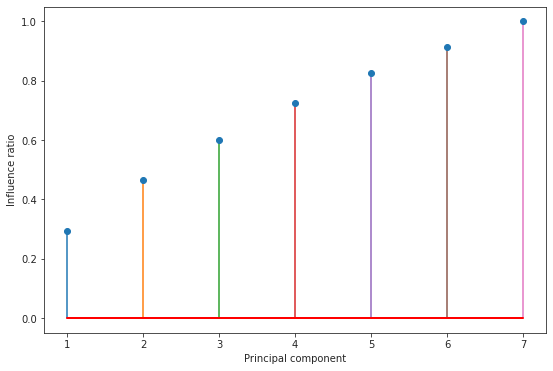

[2.88894172 1.70491617 1.31505106 1.2266716  0.99836972 0.88131636
 0.83558603]
[[-1.68016620e-01 -5.76248023e-01  4.75772328e-02  3.53342721e-01
  -1.31863806e-01 -3.18508644e-02  1.70273440e-01]
 [-5.22238332e-01  2.31683849e-01 -4.51697248e-02  4.47856330e-02
  -6.76291383e-02 -7.44106998e-02  5.59924688e-02]
 [-2.50617963e-01 -5.25706141e-01  3.65956027e-02  9.44524747e-02
  -8.52725759e-02  2.88487963e-01  2.87517346e-01]
 [-2.33002604e-01  1.81210982e-01 -1.38108328e-01 -2.69041591e-01
   1.24969326e-02  7.82418691e-01  1.93725789e-01]
 [-5.07321088e-01  1.08069313e-01 -5.07238186e-02 -2.98982947e-02
  -8.33901042e-03 -2.03567681e-01 -1.54906951e-01]
 [ 9.15884556e-04 -7.67547814e-02  9.82869448e-02 -6.28607148e-01
  -5.56077552e-02 -3.68328694e-01  6.49733032e-01]
 [-4.55418177e-02  1.77769668e-02 -4.55937952e-02  2.02749505e-01
   9.39136140e-01 -3.18523192e-02  2.63919261e-01]
 [ 4.69034805e-01 -2.06159005e-01  2.15076364e-01 -1.31728600e-01
   6.81434555e-02  1.64669520e-01 -

In [ ]:
# 调用主成分分析

art_ver, art_vec, art_val  = pca(artistData_np, 7)

np.savetxt("./res/eigVect.txt",art_vec)
pd.DataFrame(art_ver).to_csv("./res/ver.csv")

a = art_val

a = a/sum(a)

for i in range(1, len(a)):
    a[i] = a[i] + a[i-1]

x = np.linspace(1, 7, 7)

plt.figure(figsize=(9, 6))

markerline, stemlines, baseline = plt.stem(x, a, '-')

plt.setp(baseline, color='r', linewidth=2)

plt.xticks(x)

plt.xlabel('Principal component')

plt.ylabel('Influence ratio')

plt.savefig('./img/PCA_line.jpg', dpi=600)

plt.show()

print(art_val)
print(art_vec)
print(art_ver)

In [ ]:
# 主成分分析作图函数

def pca_draw2D(data, n_eigVect, columns=[ 'artist_name','artist_id', 'count', 'popularity', 'genre']):
    for i in range(6):
        _data = sc.fit_transform(np.dot(sc.fit_transform(data[data['genre'] == list (genre.keys()) [list (genre.values()).index (i)]].drop(columns=columns).to_numpy().astype(float)), n_eigVect))
        plt.scatter(_data[:,0], _data[:,1], edgecolor='none',
                alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))

    # plt.xlim((-3, 3))
    # plt.ylim((-3, 3))

def pca_draw3D(data, n_eigVect, columns=[ 'artist_name','artist_id', 'count', 'popularity', 'genre']):
    
    ax = plt.subplot(111, projection='3d')
    for i in range(6):
        _data = sc.fit_transform(np.dot(sc.fit_transform(data[data['genre'] == list (genre.keys()) [list (genre.values()).index(i)]].drop(columns=columns).to_numpy().astype(float)), n_eigVect))
        ax.scatter(_data[:,0], _data[:,1], _data[:,2])
        
    # ax.set_zlim(-2, 2)
    # plt.xlim((-3, 3))
    # plt.ylim((-3, 3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


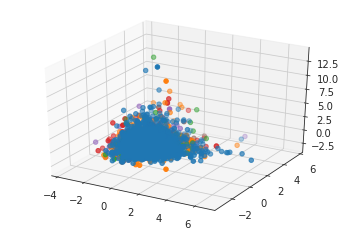

In [ ]:
# 主成分分析作图

%matplotlib inline
pca_draw2D(artistData, art_vec)

# %matplotlib notebook
# 开启jupyter notebook 交互, colab无显示

pca_draw3D(artistData, art_vec)

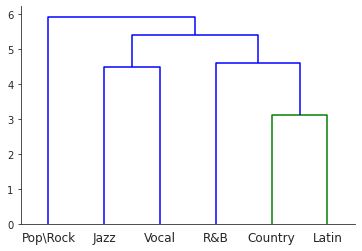

(6, 12)

In [ ]:
# 聚类算法
%matplotlib inline

label_name = np.array(['Country','Jazz','Latin','Pop\Rock','R&B','Vocal'])

cluData = sc.fit_transform(sixData_np)

Z = hierarchy.linkage(cluData, method ='average',metric='euclidean')
hierarchy.dendrogram(Z, labels=label_name)
sns.despine()

plt.savefig('./img/6Data.jpg', dpi=600)
plt.show()

cluData.shape

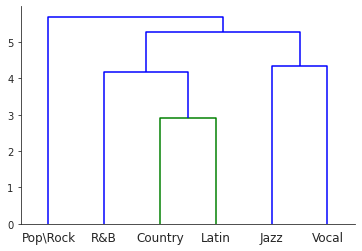

(6, 7)

In [ ]:
%matplotlib inline

label_name = np.array(['Country','Jazz','Latin','Pop\Rock','R&B','Vocal'])
cluData = (np.dot(sc.fit_transform(sixData_np), art_vec))

Z = hierarchy.linkage(cluData, method ='average',metric='euclidean')
hierarchy.dendrogram(Z, labels=label_name)

sns.despine()

plt.savefig('./img/6Data_pac.jpg', dpi=600)
plt.show()

cluData.shape

In [ ]:
# 距离矩阵函数
def disArr(ver):
    
    distA=pdist(ver,metric='euclidean')
    # 将distA数组变成一个矩阵
    distB = squareform(distA)
    
        # 计算组内和组件平均距离
    dis_arr = np.zeros((6, 6))

    for i in range(6):
        for j in range(i+1, 6):
            _row = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (i)])
            _col = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (j)])
            _data = distB[_row, :]
            _data = _data[:, _col]
            dis_sum = np.sum(_data)/(_row.shape[0] * _col.shape[0])
            dis_arr[i, j] = dis_sum

    dis_same = np.zeros((6, 6))
    for i in range(6):
        _row = np.flatnonzero(artistData['genre'] == list (genre.keys()) [list (genre.values()).index (i)])
        _data = distB[_row,:]
        _data = _data[:, _row]
        dis_sum = np.sum(_data)/(_row.shape[0] * _row.shape[0])
        dis_same[i, i] = dis_sum

    dis_arr = pd.DataFrame(dis_same) + pd.DataFrame(dis_arr)
    
    return dis_arr, distB

In [ ]:
ver = (np.dot(sc.fit_transform(artistData_np), art_vec))

# 距离矩阵计算
ver_dis_arr, ver_disB =  disArr(ver)

pd.DataFrame.to_csv(ver_dis_arr, './res/dis_arr_7_dim.csv')

_data_dis = sc.fit_transform(artistData_np)

data_dis_arr, data_disB = disArr(_data_dis)

pd.DataFrame.to_csv(data_dis_arr, './res/dis_arr.csv')

print(ver_dis_arr)
print(data_dis_arr)

         0         1         2         3         4         5
0  3.61054  3.780531  3.574001  4.804366  4.554332  3.812649
1  0.00000  3.494771  3.459513  4.585476  4.371504  3.523012
2  0.00000  0.000000  2.949228  4.418006  3.833693  3.366532
3  0.00000  0.000000  0.000000  4.089081  4.370741  4.518321
4  0.00000  0.000000  0.000000  0.000000  3.495254  4.248386
5  0.00000  0.000000  0.000000  0.000000  0.000000  3.475635
          0         1         2         3         4         5
0  4.073627  4.219618  3.986226  5.261635  4.935736  4.278945
1  0.000000  3.925867  3.854881  5.051231  4.734049  4.002608
2  0.000000  0.000000  3.337533  4.842191  4.191502  3.795095
3  0.000000  0.000000  0.000000  4.652109  4.839420  4.975161
4  0.000000  0.000000  0.000000  0.000000  3.885127  4.632725
5  0.000000  0.000000  0.000000  0.000000  0.000000  3.920471


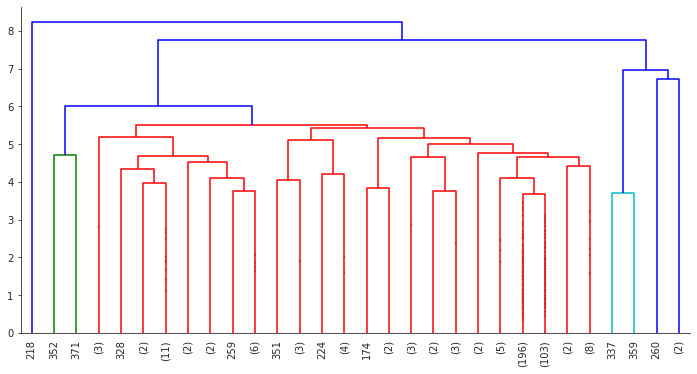

In [ ]:
# 60类聚类

# _60_art_data = np.genfromtxt("./data/60_ar.csv", dtype="int")
# _70_art_data = np.genfromtxt("./data/70_ar.csv", dtype="int")
# _80_art_data = np.genfromtxt("./data/80_ar.csv", dtype="int")

_60_art_data = np.genfromtxt("/content/drive/MyDrive/mcm/data/60_ar.csv", dtype="int")
_70_art_data = np.genfromtxt("/content/drive/MyDrive/mcm/data/70_ar.csv", dtype="int")
_80_art_data = np.genfromtxt("/content/drive/MyDrive/mcm/data/80_ar.csv", dtype="int")

artistData['artist_id'] = artistData['artist_id'].astype('int')

_60_art =  artistData[artistData['artist_id'].isin(_60_art_data)]
_70_art =  artistData[artistData['artist_id'].isin(_70_art_data)]
_80_art =  artistData[artistData['artist_id'].isin(_80_art_data)]

_60_art_np = _60_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
_70_art_np = _70_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
_80_art_np = _80_art.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)

_60_art_np = np.dot(sc.fit_transform(_60_art_np), art_vec)
_70_art_np = np.dot(sc.fit_transform(_70_art_np), art_vec)
_80_art_np = np.dot(sc.fit_transform(_80_art_np), art_vec)

# _60_art_np = sc.fit_transform(_60_art_np)
# _70_art_np = sc.fit_transform(_60_art_np)


plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_60_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/60_clu.jpg', dpi = 600)

plt.show()

_60_art.to_csv('./res/_60_art.csv')


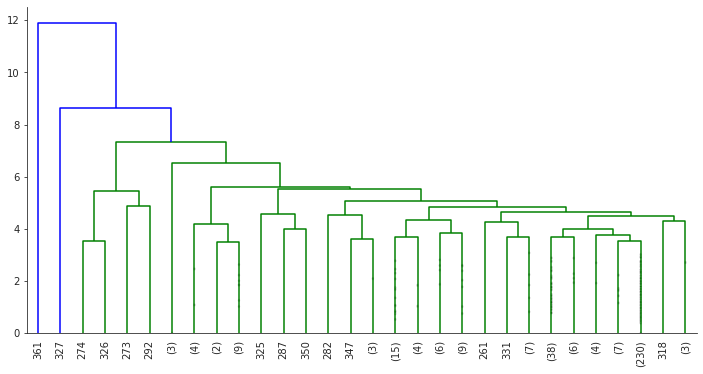

In [ ]:
plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_70_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/70_clu.jpg', dpi = 600)

plt.show()

_70_art.to_csv('./res/_70_art.csv')

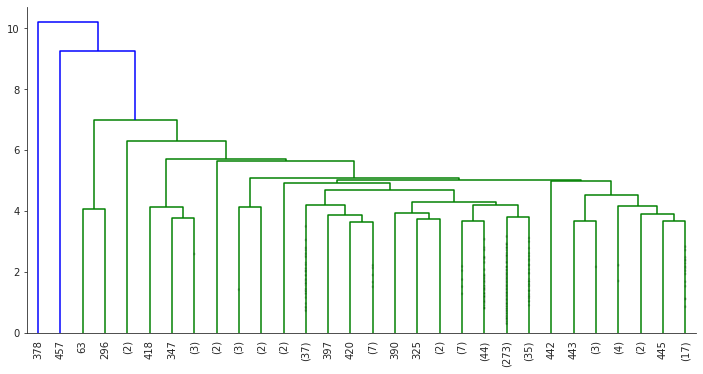

In [ ]:
plt.figure(figsize=(12, 6))

Z = hierarchy.linkage(_80_art_np, method ='average',metric='euclidean')

hierarchy.dendrogram(Z, leaf_rotation=90., leaf_font_size=10., show_contracted=True, truncate_mode='lastp')

sns.despine()
plt.savefig('./img/80_clu.jpg', dpi = 600)

plt.show()

_80_art.to_csv('./res/_80_art.csv')

In [ ]:
T = fcluster(Z, 3, criterion='distance')
T

array([37, 31, 30, 31, 28, 31, 30, 30, 30, 30, 29, 29, 29, 31, 29, 33, 31,
       29, 29, 34, 31, 34, 30, 30, 29, 29, 29, 28, 34, 28, 29, 30, 30, 31,
       30, 29, 29, 30, 29, 30, 28, 29, 30, 29, 30, 18, 29, 29, 34, 42, 30,
       30, 29, 29, 18, 34, 30, 29, 29, 28, 30, 29, 28,  1, 34, 30, 30, 30,
       33, 29, 30, 27, 28, 30, 30, 31, 29, 29, 29, 28, 42, 30, 28, 29, 29,
       29, 30, 30, 29, 29, 30, 33, 30, 30, 34, 29, 28, 31, 30, 18, 42, 42,
       30, 31, 29, 27, 30, 30, 28, 30, 28, 29, 30, 34, 29, 17, 30, 30, 27,
       30, 28, 26, 37, 28, 30, 29, 33, 28, 29, 31, 31, 29, 28, 30, 31, 17,
       25, 29, 28, 29, 42, 33, 18, 30, 30, 29, 31, 30, 30, 33, 30, 30, 30,
       29, 30, 29, 19, 30, 29, 33, 30, 31, 30, 28, 30, 18, 29, 29, 28, 30,
       30, 29, 31, 30, 34, 29, 30, 22, 31, 29, 29, 28, 31, 30, 30, 18, 19,
       30, 18, 29, 42, 19, 30, 29, 28, 34, 31, 31, 18, 18, 30, 30, 17, 30,
       30, 28, 31, 30, 30, 31, 31, 30, 27, 29, 29, 29, 30, 28, 31, 29, 25,
       29, 25, 29,  8, 29

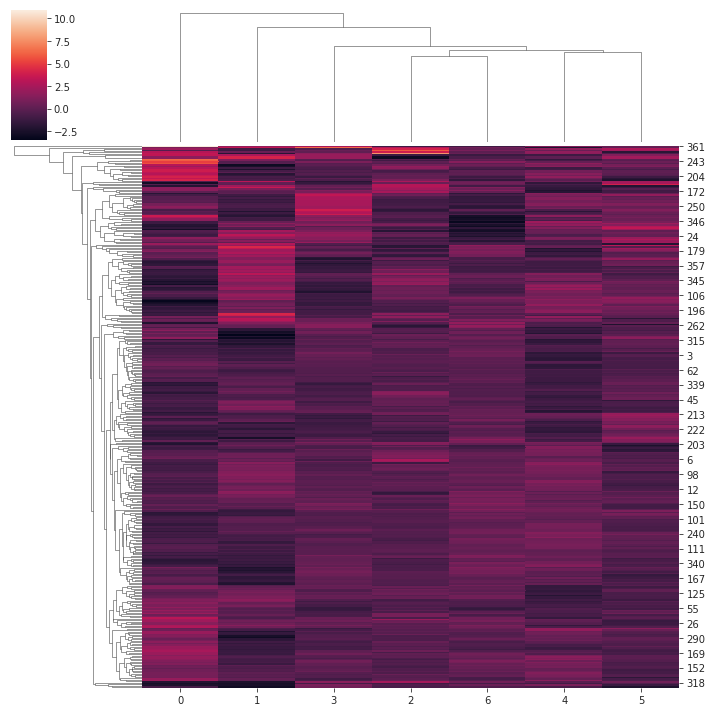

In [ ]:
# 聚类树图



# plt.figure(figsize=(50, 50))
g = sns.clustermap(_70_art_np)
plt.show()

In [ ]:
pd.DataFrame(Z)

,0,1,2,3
0,51.0,160.0,0.311068,2.0
1,154.0,176.0,0.325319,2.0
2,8.0,332.0,0.389497,2.0
3,208.0,249.0,0.447009,2.0
4,18.0,47.0,0.457101,2.0
...,...,...,...,...
452,898.0,909.0,5.716551,452.0
453,863.0,910.0,6.304833,454.0
454,896.0,911.0,6.986218,456.0
455,457.0,912.0,9.254814,457.0


In [ ]:
# 从此往下为 12类特征展示

fullData_6 = fullData[(fullData['genre'] == 'Pop/Rock') | (fullData['genre'] == 'R&B;') | (fullData['genre'] == 'Country') | (fullData['genre'] == 'Jazz') | (fullData['genre'] == 'Vocal') | (fullData['genre'] == 'Latin')]
fullData_6

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
3,"[""Alexander O'Neal""]",[625201],0.761,0.702,0.850,104.773,-8.523,1.0,7.0,0.10800,0.000031,0.0935,0.0389,0.0,304427.0,34.0,1991.0,1/1/1991,All True Man,R&B;
4,"[""Alexander O'Neal""]",[625201],0.661,0.828,0.902,115.078,-12.673,0.0,11.0,0.27600,0.000001,0.2870,0.0390,0.0,264933.0,37.0,1987.0,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
5,"[""Alexander O'Neal""]",[625201],0.719,0.650,0.953,105.141,-12.947,0.0,7.0,0.01030,0.000044,0.1330,0.0265,0.0,277773.0,34.0,1987.0,7/29/1987,The Lovers,R&B;
6,"[""Alexander O'Neal""]",[625201],0.649,0.245,0.273,112.709,-17.585,1.0,11.0,0.49600,0.000000,0.1740,0.0286,0.0,312733.0,29.0,1987.0,7/29/1987,Crying Overtime,R&B;
7,"[""Alexander O'Neal""]",[625201],0.701,0.715,0.735,101.515,-14.999,0.0,11.0,0.06000,0.000000,0.3540,0.0291,0.0,241107.0,32.0,1987.0,7/29/1987,Hearsay,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,['Aerosmith'],[604852],0.324,0.869,0.323,127.908,-10.112,1.0,7.0,0.13100,0.112000,0.7580,0.0620,0.0,265293.0,22.0,1978.0,10/1/1978,Back in the Saddle - Live at Market Square Are...,Pop/Rock
5850,['Aerosmith'],[604852],0.371,0.904,0.569,95.850,-9.861,1.0,2.0,0.01000,0.000012,0.2050,0.0546,0.0,221040.0,24.0,1985.0,1/1/1985,The Hop,Pop/Rock
5851,['Aerosmith'],[604852],0.317,0.746,0.244,119.216,-9.929,0.0,5.0,0.10800,0.000000,0.1720,0.0600,0.0,223600.0,24.0,1985.0,1/1/1985,Darkness,Pop/Rock
5852,['Aerosmith'],[604852],0.752,0.830,0.923,105.793,-3.291,0.0,6.0,0.01650,0.000032,0.0691,0.0550,0.0,309200.0,21.0,1986.0,5/15/1986,Walk This Way (feat. Aerosmith),Pop/Rock


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

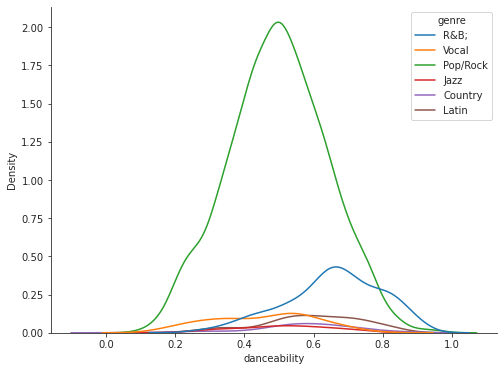

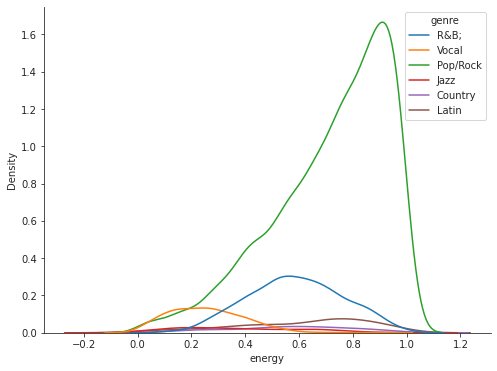

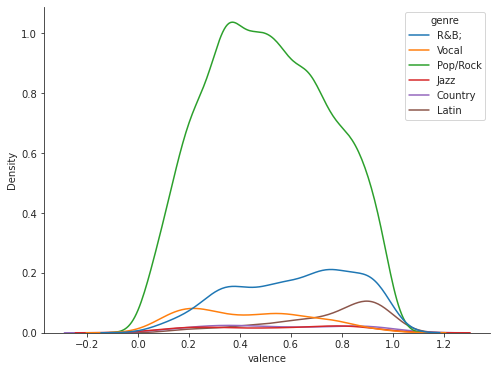

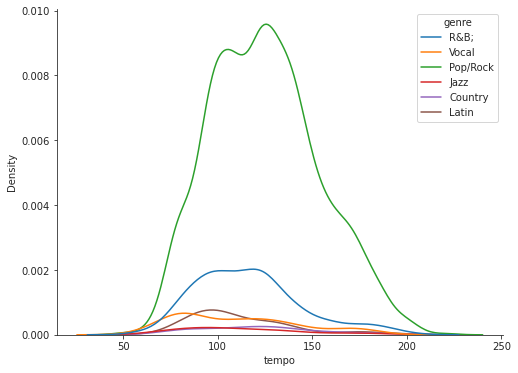

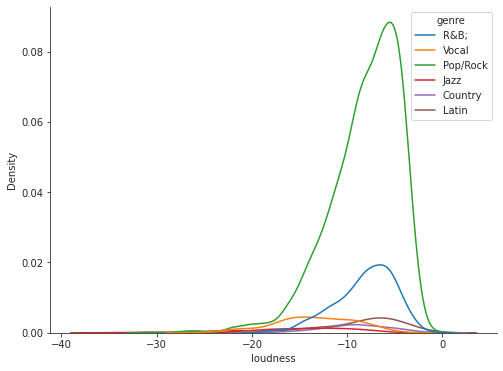

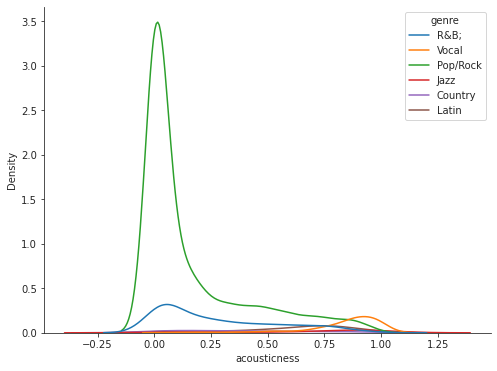

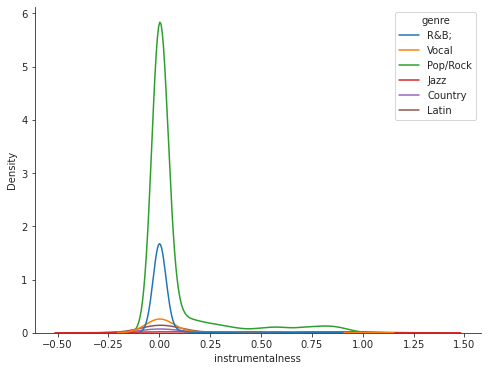

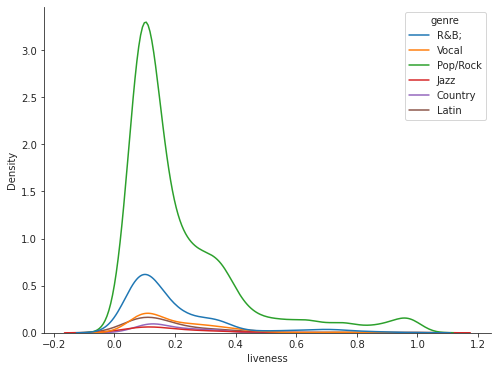

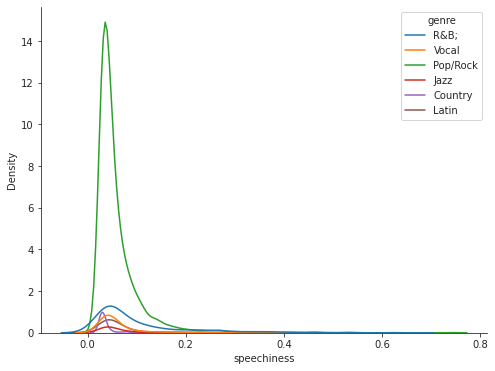

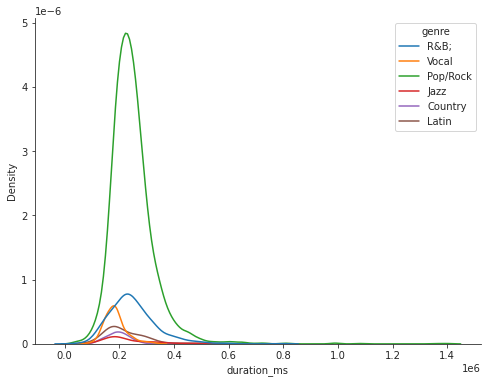

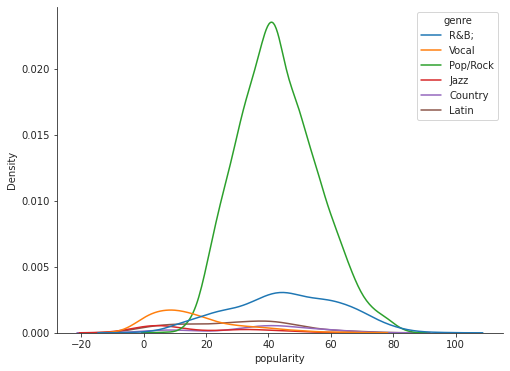

In [ ]:
fullData_6['danceability'] = fullData_6['danceability'].astype('float')

plt.figure(figsize=(8, 6))


sns.kdeplot(
   data=fullData_6, x='danceability', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.2, linewidth=0,
)
sns.despine()
plt.savefig('./img/danceability.jpg', dpi=600)

plt.figure(figsize=(8, 6))

fullData_6['energy'] = fullData_6['energy'].astype('float')


sns.kdeplot(

   data=fullData_6, x='energy', hue='genre',
#     fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/energy.jpg', dpi=600)

fullData_6['valence'] = fullData_6['valence'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='valence', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/valence.jpg', dpi=600)

fullData_6['tempo'] = fullData_6['tempo'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='tempo', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.3, linewidth=0,
)
sns.despine()
plt.savefig('./img/tempo.jpg', dpi=600)


fullData_6['loudness'] = fullData_6['loudness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='loudness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/loudness.jpg', dpi=600)

fullData_6['acousticness'] = fullData_6['acousticness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='acousticness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/acousticness.jpg', dpi=600)

fullData_6['instrumentalness'] = fullData_6['instrumentalness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='instrumentalness', hue='genre',
#    fill=True, common_norm=False, palette="bright",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/instrumentalness.jpg', dpi=600)

fullData_6['liveness'] = fullData_6['liveness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='liveness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/liveness.jpg', dpi=600)

fullData_6['speechiness'] = fullData_6['speechiness'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='speechiness', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/speechiness.jpg', dpi=600)

fullData_6['duration_ms'] = fullData_6['duration_ms'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='duration_ms', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/duration_ms.jpg', dpi=600)

fullData_6['popularity'] = fullData_6['popularity'].astype('float')

plt.figure(figsize=(8, 6))

sns.kdeplot(
   data=fullData_6, x='popularity', hue='genre',
#    fill=True, common_norm=False, palette="crest",
#    alpha=.4, linewidth=0,
)
sns.despine()
plt.savefig('./img/popularity.jpg', dpi=600)




In [ ]:
# 计算网络图邻接矩阵

graph = np.zeros((influenceData.shape[0], 2))

minYear = int(min(min(influenceData['influencer_active_start']), min(influenceData['follower_active_start'])))

minYear

maxYear = int(max(max(influenceData['influencer_active_start']), max(influenceData['follower_active_start'])))

for row_index, row  in influenceData.iterrows():
    # print(row_index, row['influencer_main_genre'])
    
    graph[row_index][0] = genre[row['influencer_main_genre']] + int((int(row['influencer_active_start']) - minYear)/10)* 20
    graph[row_index][1] = genre[row['follower_main_genre']] + int((int(row['follower_active_start']) - minYear)/10) * 20


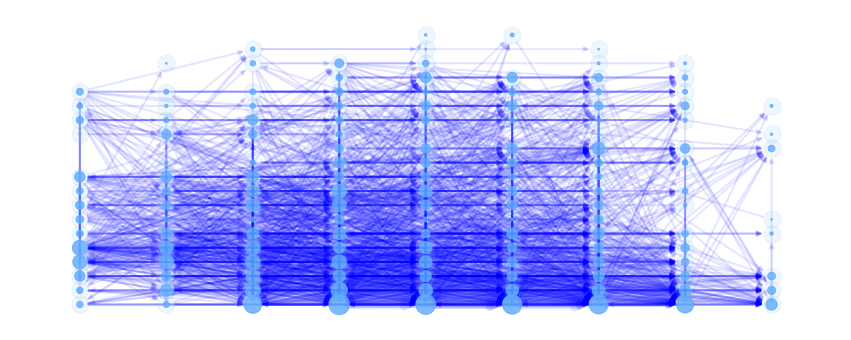

In [ ]:
# 通过邻接矩阵作图
%matplotlib inline
graph = graph.astype(int)

G = nx.Graph()

G.clear()

row = np.array(graph[:, 0])
col = np.array(graph[:, 1])

data = np.ones((1, graph.shape[0])).reshape(-1)

n = max(max(row), max(col)) + 1

pos = {}

for i in range((maxYear - minYear + 10)*2):
    pos[i] = (i // 20, i % 20)

A = csr_matrix((data, (row, col)), shape=(n, n)).toarray()

A = np.where(A < 0, 0, A).astype('int')

G = nx.from_numpy_matrix(A, create_using=nx.DiGraph()) 

_be_d = dict(G.degree)

G.remove_nodes_from(list(nx.isolates(G)))

# G = G.to_directed()

color_list = [float(v['weight']*0.5) for (r,c,v) in G.edges(data=True)]

color_list = [int(((i/max(color_list))*8 + 2)) for i in color_list]

d = dict(G.degree)

plt.figure(figsize=(15, 6))


plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G,
        pos,
        width=color_list,
        node_color="#60acfc",
        edge_color = 'b',
        alpha = 0.1
       )
nx.draw_networkx_nodes(G,pos, node_color="#60acfc",node_size=[v * 3 for v in d.values()], alpha=0.8)

plt.savefig('./img/all_network.jpg', dpi = 600)

plt.show() 

A_all = A

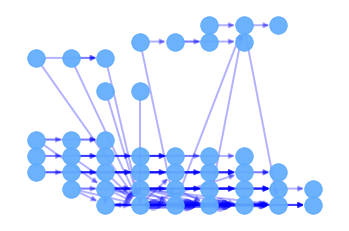

In [ ]:
# 通过邻接矩阵作图
%matplotlib inline
graph = graph.astype(int)

G = nx.Graph()

G.clear()

row = np.array(graph[:, 0])
col = np.array(graph[:, 1])

data = np.ones((1, graph.shape[0])).reshape(-1)

n = max(max(row), max(col)) + 1

pos = {}

for i in range((maxYear - minYear + 10)*2):
    pos[i] = (i // 20, i % 20)

A = csr_matrix((data, (row, col)), shape=(n, n)).toarray()

A = np.where(A < 50, 0, A).astype('int')

G = nx.from_numpy_matrix(A, create_using=nx.DiGraph()) 

_be_d = dict(G.degree)

G.remove_nodes_from(list(nx.isolates(G)))

# G = G.to_directed()

color_list = [float(v['weight']*0.5) for (r,c,v) in G.edges(data=True)]

color_list = [int(((i/max(color_list))*8 + 2)) for i in color_list]

# d = dict(G.degree)

# plt.figure(figsize=(15, 6))


plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G,
        pos,
        width=color_list,
        node_color="#60acfc",
        edge_color = 'b',
        alpha = 0.3
       )
nx.draw_networkx_nodes(G,pos, node_color="#60acfc",
#                        node_size=[v * 3 for v in d.values()],
                       alpha=0.9
                      )

plt.savefig('./img/all_network_50.jpg', dpi = 600)

plt.show() 

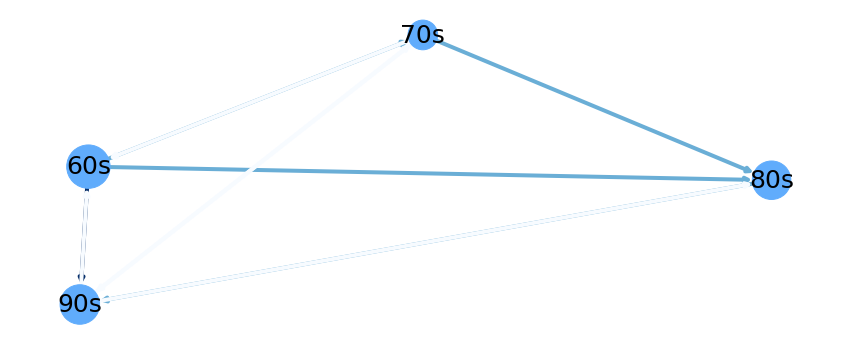

In [ ]:
# subnet
A = A_all

sublist = [65, 85, 105, 125]

sub_A = np.zeros((4, 4))

# pos_sub = [(0,0), (1,0), (2,0),(3,0)]

for i in range(len(sublist)):
    for j in range(len(sublist)):
        sub_A[i, j] = A[sublist[i], sublist[j]]

G_sub = nx.from_numpy_matrix(sub_A, create_using=nx.DiGraph()) 

G_sub.remove_nodes_from(list(nx.isolates(G_sub)))

color_list = [float(v['weight']*0.5) for (r,c,v) in G_sub.edges(data=True)]

color_list = [int(((i/max(color_list))*2 + 2)) for i in color_list]

d_sub = {k:v for k,v in d.items() if k in sublist}

plt.figure(figsize=(15, 6))

label = {0: '60s', 1:'70s', 2:'80s', 3:'90s'}

plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G_sub,
#         pos = pos,
        width=4,
        node_color="#60acfc",
        edge_color =color_list,
        edge_cmap=plt.cm.Blues,
#         alpha = 0.5,
        node_size=[v * 40 for v in d_sub.values()],
        # with_labels = False,
        labels = label,
        font_size = 25
       )

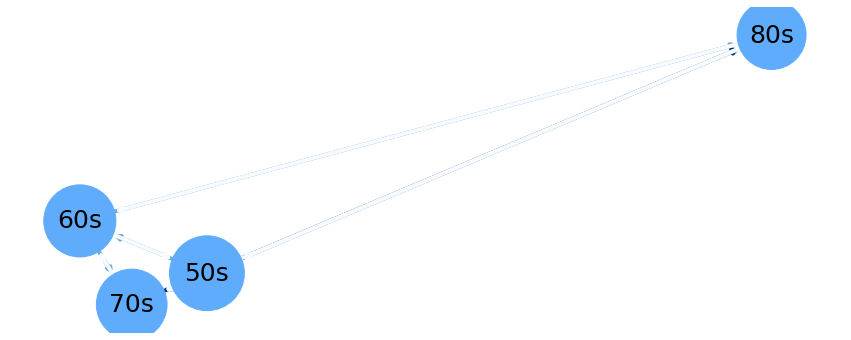

In [ ]:
# subnet
A = A_all

sublist = [60, 80, 100, 120]
sub_A = np.zeros((4, 4))

# pos_sub = [(0,0), (1,0), (2,0),(3,0)]

for i in range(len(sublist)):
    for j in range(len(sublist)):
        sub_A[i, j] = A[sublist[i], sublist[j]]

G_sub = nx.from_numpy_matrix(sub_A, create_using=nx.DiGraph()) 

G_sub.remove_nodes_from(list(nx.isolates(G_sub)))

color_list = [float(v['weight']*0.5) for (r,c,v) in G_sub.edges(data=True)]

color_list = [int(((i/max(color_list))*2 + 2)) for i in color_list]

d_sub = {k:v for k,v in d.items() if k in sublist}

plt.figure(figsize=(15, 6))

label = {0: '50s', 1:'60s', 2:'70s', 3:'80s'}

plt.axis("off")
# nx.draw(G, pos, node_color="#A0CBE2", edge_color="#aaaaaa")
nx.draw(G_sub,
#         pos = pos,
        width=4,
        node_color="#60acfc",
        edge_color =color_list,
        edge_cmap=plt.cm.Blues,
#         alpha = 0.5,
        node_size=[v * 40 for v in d_sub.values()],
        # with_labels = False,
        labels = label,
        font_size = 25
       )

In [ ]:
# 将fullData 通过不同年份和不同流派分割
minYear = int(min(fullData['year']))

minYear = round(minYear/10)*10

maxYear = int(max(fullData['year']))

maxYear = math.ceil(maxYear/10)*10

fullData['year'] = fullData['year'].astype('int')

# 正常数据
for i in range(6):
    
    _table = pd.DataFrame(columns=fullData.iloc[:, 2:17].columns).drop(columns=['explicit'])
    
    for j in range(int((maxYear - minYear)/10)):
        _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (i)]) & (fullData['year'] >= minYear + j * 10) & (fullData['year'] < minYear + (j+1) * 10)].iloc[:, 2:17].drop(columns=['explicit'])
        a = _data.astype('float').mean()
        a['year'] = minYear + j * 10
        _table = _table.append(a, ignore_index=True)
    
    pd.DataFrame(sc.fit_transform(_table)).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (i)][0:3]+".csv")

_table = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (0)]) & (fullData['year'] == minYear + j) ].iloc[:, 2:17].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    a = a 
    a['year'] = minYear + j
    _table = _table.append(a, ignore_index=True)

pd.DataFrame(sc.fit_transform(_table)).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (0)][0:3]+"_1.csv")

# 降维数据
full_ver, full_n_eigVect, full_eigInd = pca(fullData_np, 7)

N_ei = pd.DataFrame(full_n_eigVect)

all_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])

for i in range(6):
    
    _table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
    for j in range(int((maxYear - minYear)/10)):
        _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (i)]) & (fullData['year'] >= minYear + j * 10) & (fullData['year'] < minYear + (j+1) * 10)].iloc[:, 2:15].drop(columns=['explicit'])
        a = _data.astype('float').mean()
        _table_7 = _table_7.append(a, ignore_index=True)
        
    pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), full_n_eigVect))).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (i)][0:3]+"_7_dim.csv")

    _table_7['genre'] = list (genre.keys()) [list (genre.values()).index (i)]
    all_table_7 = all_table_7.append(_table_7, ignore_index=True)
    
_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])
    
for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['genre'] == list (genre.keys()) [list (genre.values()).index (2)]) & (fullData['year'] == minYear + j) ].iloc[:, 2:15].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    _table_7 = _table_7.append(a, ignore_index=True)
pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), full_n_eigVect))).to_csv("./res/"+ list(genre.keys()) [list (genre.values()).index (2)][0:3]+"_1_7_dim.csv")



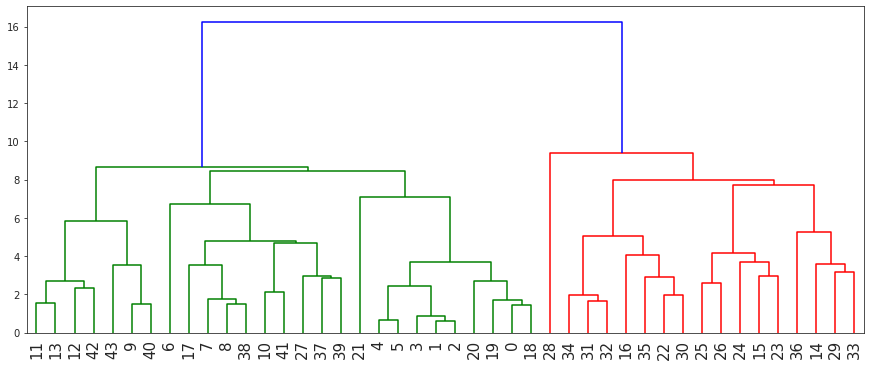

In [ ]:
# all_table 聚类

all_table_7 = all_table_7.dropna(how = 'any')

all_table_7_np = all_table_7.drop(columns=['genre']).to_numpy().astype('float')

all_table_7_np = sc.fit_transform(all_table_7_np)

# Convert the palette to vectors that will be drawn on the side of the matrix
# networks = df.columns.get_level_values("network")
# network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# g = sns.clustermap(all_table_7_np, cmap="mako",
#                    col_cluster = False,
#                    figsize=(20, 20),
#                    standard_scale=1
# #                    row_colors=network_colors, col_colors=network_colors,
# #                    dendrogram_ratio=(.1, .2),
# #                    cbar_pos=(.02, .32, .03, .2),
# #                    linewidths=.75, figsize=(12, 13)
#                   )

plt.figure(figsize=(15, 6))

Z = hierarchy.linkage(all_table_7_np, method ='ward',metric='euclidean')

hierarchy.dendrogram(Z, show_leaf_counts=True, leaf_font_size=15., show_contracted=True)

plt.savefig('./img/all_table.jpg', dpi=600)

plt.show()

# _60_art.to_csv('./res/_60_art.csv')

In [ ]:
all_table_7

,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,genre
4,0.510011,0.600638,0.611809,117.673085,-9.323936,0.787234,4.691489,0.301912,1.327142e-01,0.169524,0.044448,202079.074468,Pop/Rock
5,0.498949,0.660329,0.545110,124.083754,-9.255037,0.779528,5.444882,0.245587,7.476029e-02,0.238011,0.060103,259209.685039,Pop/Rock
6,0.484351,0.703225,0.519702,124.752431,-9.715507,0.739570,5.446271,0.158136,1.066445e-01,0.242319,0.052600,255766.678887,Pop/Rock
7,0.512966,0.726978,0.519593,121.253756,-8.249595,0.762712,5.696610,0.128442,7.191798e-02,0.215698,0.058471,253165.664407,Pop/Rock
8,0.495254,0.789033,0.465395,128.121005,-5.831603,0.708134,5.328549,0.093754,4.960638e-02,0.201319,0.065019,241802.288676,Pop/Rock
9,0.491438,0.761577,0.454038,132.264133,-5.710454,0.665138,5.027523,0.139706,3.600287e-02,0.178859,0.071128,227069.160550,Pop/Rock
10,0.845000,0.455000,0.896000,87.002000,-13.668000,0.000000,5.000000,0.710000,4.200000e-01,0.055000,0.048800,145933.000000,R&B;
13,0.534894,0.538936,0.737766,122.503000,-9.188468,0.872340,5.021277,0.710851,1.991644e-02,0.236426,0.064198,147240.829787,R&B;
14,0.563447,0.500184,0.779474,113.249368,-9.549105,0.894737,5.184211,0.463677,3.170762e-02,0.183237,0.043334,159746.684211,R&B;
15,0.631968,0.605587,0.704190,118.366111,-9.754127,0.603175,4.238095,0.317886,5.047617e-02,0.286178,0.074837,335596.015873,R&B;


In [ ]:
# only year 7dim
_table_7 = pd.DataFrame(columns=fullData.iloc[:, 2:15].columns).drop(columns=['explicit'])

# for j in range(int((maxYear - minYear))):
#     _data = fullData[(fullData['year'] == minYear + j) ].iloc[:, 2:15].drop(columns=['explicit'])
#     a = _data.astype('float').mean()
#     _table_7 = _table_7.append(a, ignore_index=True)
# pd.DataFrame(sc.fit_transform(np.dot(sc.fit_transform(_table_7.to_numpy()), n_eigVect))).to_csv("./res/only_year_1_7_dim.csv")

for j in range(int((maxYear - minYear))):
    _data = fullData[(fullData['year'] == minYear + j) ].iloc[:, 2:17].drop(columns=['explicit'])
    a = _data.astype('float').mean()
    _table_7 = _table_7.append(a, ignore_index=True)
pd.DataFrame(sc.fit_transform(_table_7)).to_csv("./res/only_year_1.csv")

print(minYear)
print(maxYear)

1920
2020


In [ ]:
_table_7

,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.375500,0.189100,0.497000,143.028500,-19.281500,1.000000,3.000000,0.992500,0.348850,0.392500,0.040650,234687.000000,0.000000,1921.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.551600,0.748667,0.435400,133.508367,-5.731433,0.566667,5.333333,0.189709,0.087961,0.149543,0.070517,227212.833333,59.733333,2015.0
96,0.545438,0.594771,0.408367,124.871021,-6.725229,0.520833,4.979167,0.212169,0.045550,0.182438,0.078935,238696.958333,63.604167,2016.0
97,0.559312,0.525562,0.357694,104.157375,-8.241875,0.687500,4.562500,0.370814,0.106248,0.106694,0.075787,240457.250000,66.250000,2017.0
98,0.626867,0.642667,0.437063,124.956133,-5.645967,0.600000,5.500000,0.148426,0.001239,0.140463,0.101160,190478.266667,69.366667,2018.0


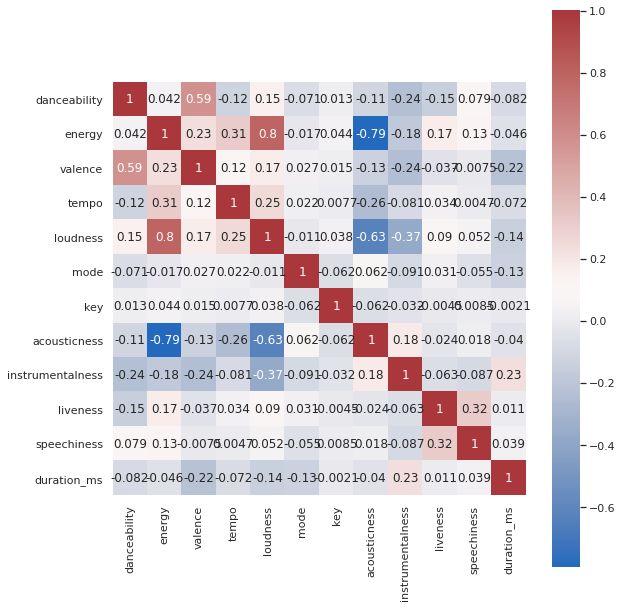

In [ ]:
sns.set_theme(style="whitegrid")

# a = np.loadtxt('./data/相关系数.txt')
a = np.loadtxt('/content/drive/MyDrive/mcm/data/相关系数.txt')

a = pd.DataFrame(a)
a.index = artistData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).columns
a.columns = a.index

plt.figure(figsize=(9,9))

g = sns.heatmap(data = a, cmap="vlag", square=True, annot=True)

plt.tight_layout()

plt.savefig('./img/相关系数.jpg', dpi = 600)